In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
import scipy as sc
import scipy.signal as scp
import numpy.random as random
from scipy.io import wavfile
from IPython.display import Audio

/tmp/ipykernel_717/3287005864.py:5: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, signal = wavfile.read(data_path + "yksi.wav")


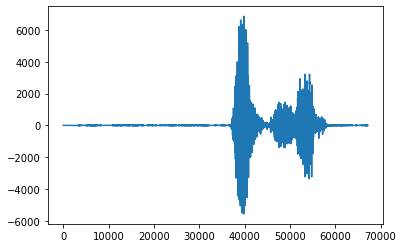

In [52]:
# Variables

data_path = "./data/"

fs, signal = wavfile.read(data_path + "yksi.wav")

plt.plot(signal)
plt.show()

In [67]:
# all data processing functions

def generate_noisy(data):
    """
    Generate two noisy variants of data.
    noise is normally distributed
    """
    return data + random.normal(0,1,len(data)) * max(abs(data)) * 0.01


    

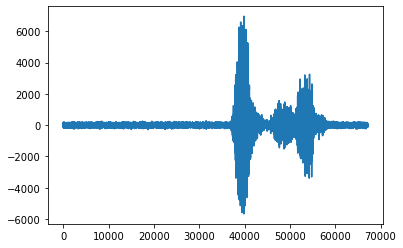

In [68]:
plt.plot(generate_noisy(signal))
plt.show()